# Shapelets
See whether I can use something like shapelets to classify the EEG signals:

Sources: 
- https://tslearn.readthedocs.io/en/stable/user_guide/shapelets.html
- https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelet_distances.html#sphx-glr-auto-examples-classification-plot-shapelet-distances-py


In [27]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne

from utils import load_eeg, load_labels, plot_eeg, get_event_epochs, markers


In [28]:
data_dir = Path("~/Data").expanduser() / "bci-i-idun-eeg-analysis-challenge"

# load the data
SUBJECT = "S001"  # [S001-3 are in the training set, S004 is in the test set]
eeg = load_eeg(data_dir, SUBJECT)

Creating RawArray with float64 data, n_channels=1, n_times=5394412
    Range : 0 ... 5394411 =      0.000 ... 21577.644 secs
    Range : 0 ... 5394411 =      0.000 ... 21577.644 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>


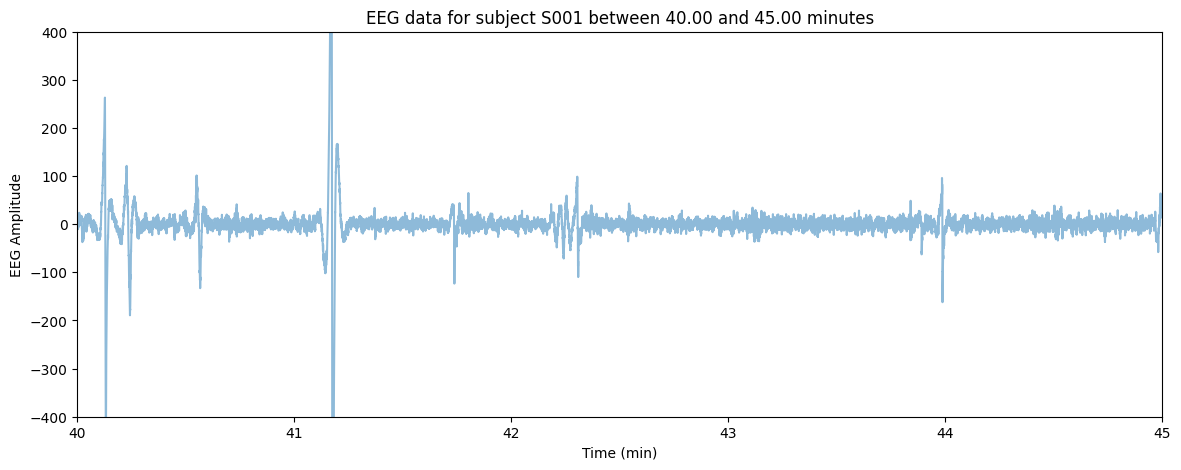

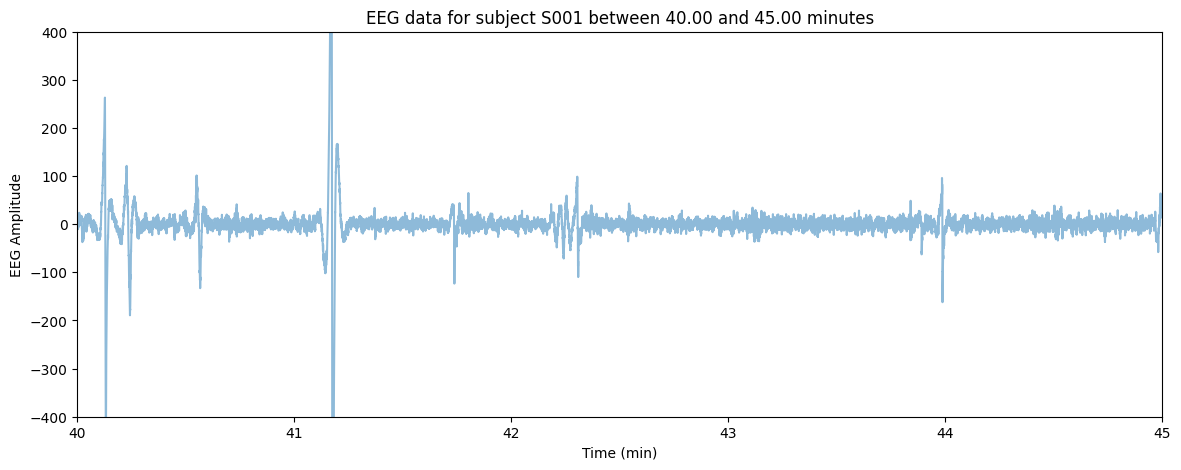

In [29]:
# this function plots the EEG data. You can pass a start/end time in minutes to zoom in on a particular time window
plot_eeg(eeg, SUBJECT, 40, 45)[0]

In [40]:
# load the labels
labels = load_labels(data_dir, SUBJECT)
labels.head()

labels["Marker"].value_counts()

S       210
K       199
REM     170
Son      29
A        22
Soff     18
MS        7
Name: Marker, dtype: int64

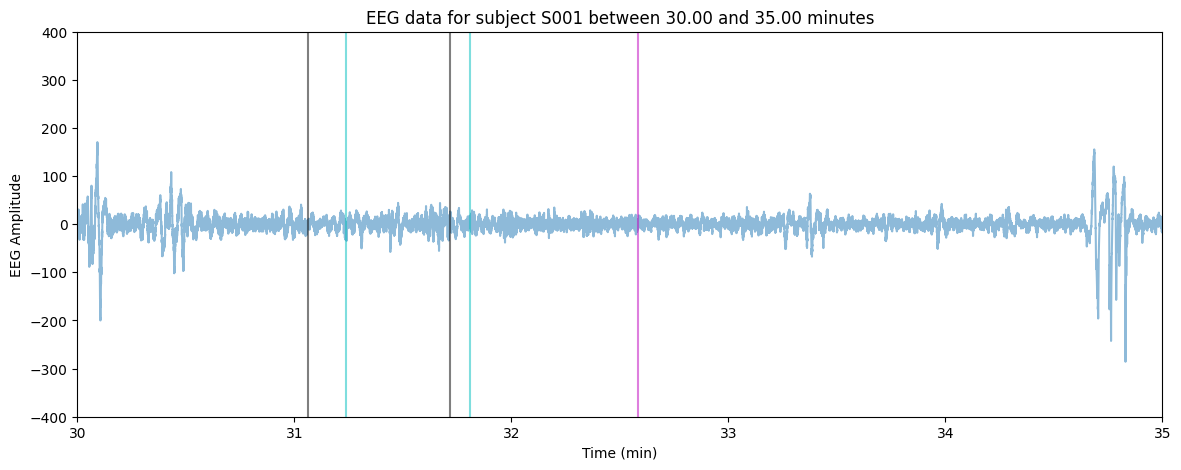

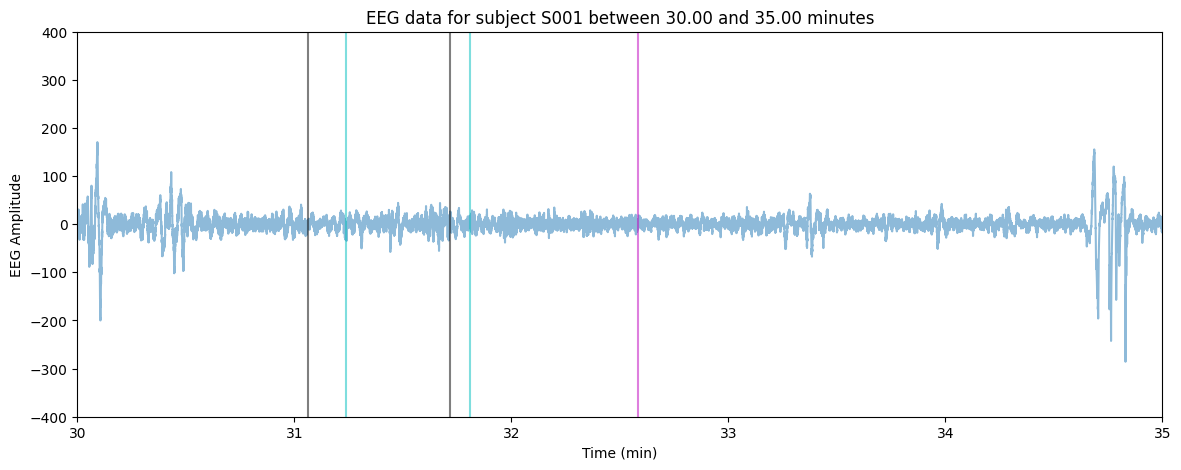

In [31]:
plot_eeg(eeg, SUBJECT, 30, 35, labels)[0]

Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 170 events and 7501 original time points ...
0 bad epochs dropped
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated


/Users/jantinebroek/Projects/kaggle/bci_eeg/utils.py:65: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events=events, tmin=tmin, tmax=tmax, baseline=None, preload=True)


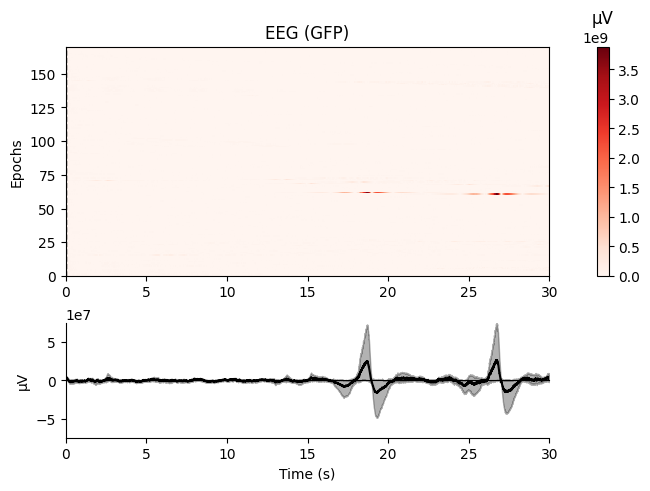

[<Figure size 640x480 with 3 Axes>]

In [32]:
epochs = get_event_epochs(eeg, labels, 'REM')
epochs.plot_image()

In [33]:
# Loading Pre-processed data
X = np.load(data_dir / f"{SUBJECT}_X.npy")
Y = np.load(data_dir / f"{SUBJECT}_Y.npy")

print(X.shape, Y.shape)
Y[:5]

(655, 7501) (655,)


array(['S', 'S', 'S', 'S', 'S'], dtype='<U4')

In [34]:
def print_class_proportions(Y, label:str):
    counts = {m: len(np.where(Y == m)[0]) for m in markers}
    percents = {m: round(counts[m]/len(Y) * 100, 2) for m in markers}
    summary = pd.DataFrame({'Count': counts, 'Percent': percents})
    # sort by count
    summary = summary.sort_values(by='Count', ascending=False)
    print(f"\n{label} dataset:")
    print(summary)


# counts for the whole dataset
print_class_proportions(Y, "Whole dataset")


Whole dataset dataset:
      Count  Percent
S       210    32.06
K       199    30.38
REM     170    25.95
Son      29     4.43
A        22     3.36
Soff     18     2.75
MS        7     1.07


In [35]:
from sklearn.model_selection import train_test_split

# the classess are not balanced, so we need to stratify the split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print_class_proportions(y_train, "Training set")
print_class_proportions(y_test, "Test set")


Training set dataset:
      Count  Percent
S       161    30.73
K       160    30.53
REM     147    28.05
Son      23     4.39
A        17     3.24
Soff     11     2.10
MS        5     0.95

Test set dataset:
      Count  Percent
S        49    37.40
K        39    29.77
REM      23    17.56
Soff      7     5.34
Son       6     4.58
A         5     3.82
MS        2     1.53


In [36]:
from sklearn.preprocessing import StandardScaler

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Shapelets

In [42]:
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [43]:
# Reshape the data to fit the shapelet model requirements
# Shapelet model expects data in the form (n_samples, n_timestamps, n_features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Scale the data using TimeSeriesScalerMinMax
scaler_minmax = TimeSeriesScalerMinMax()
X_train = scaler_minmax.fit_transform(X_train)
X_test = scaler_minmax.transform(X_test)

# Define shapelet sizes and the number of shapelets per size
shapelet_sizes = {20: 2}

# Initialize the shapelet model
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(learning_rate=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=False,
                            random_state=42)

# Fit the model on the training data
shp_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = shp_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Users/jantinebroek/miniconda3/envs/DL/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Accuracy: 0.3130


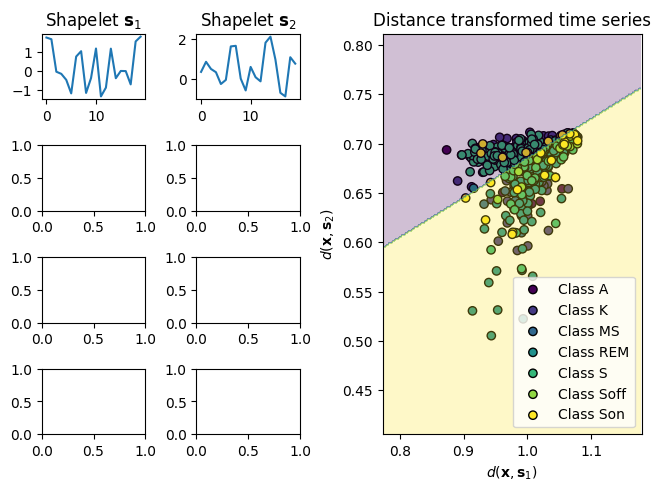

Test accuracy: 0.31297709923664124


In [44]:
# Plot the shapelets
# Plot distances in 2D space
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights("classification")

# Create a grid for our two shapelets on the left and distances on the right
viridis = plt.get_cmap('viridis', 7)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3 = [fig.add_subplot(gs[i, :2]) for i in range(1, 4)]
fig_ax4 = [fig.add_subplot(gs[i, 2:4]) for i in range(1, 4)]
fig_ax5 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i in range(7):
    for ts in X_train[y_train == i]:
        fig_ax3[i % 3].plot(ts.flatten(), c=viridis(i / 6), alpha=0.25)
        fig_ax3[i % 3].set_title('Class {}'.format(i))

# # Create the time series of each class
# for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d]):
#     for k, ts in enumerate(X_train[y_train == i + 1]):
#         subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
#         subfig.set_title('Class {}'.format(i + 1))
# fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(np.unique(y_train)):
    fig_ax5.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 6)] * np.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# # Create a scatter plot of the 2D distances for the time series of each class.
# for i, y in enumerate(np.unique(y_train)):
#     fig_ax4.scatter(distances[y_train == y][:, 0],
#                     distances[y_train == y][:, 1],
#                     c=[viridis(i / 3)] * np.sum(y_train == y),
#                     edgecolors='k',
#                     label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = np.min(distances[:, 0]) - 0.1
xmax = np.max(distances[:, 0]) + 0.1
ymin = np.min(distances[:, 1]) - 0.1
ymax = np.max(distances[:, 1]) + 0.1
xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
                        np.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(7)]))
Z = np.array(Z).reshape(xx.shape)
cs = fig_ax5.contourf(xx, yy, Z / 6, cmap=viridis, alpha=0.25)

fig_ax5.legend()
fig_ax5.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax5.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax5.set_xlim((xmin, xmax))
fig_ax5.set_ylim((ymin, ymax))
fig_ax5.set_title('Distance transformed time series')
plt.show()

# Use testing data to evaluate the model
acc = shp_clf.score(X_test, y_test)  # Get the accuracy of the model
print("Test accuracy:", acc)

# # Create a meshgrid of the decision boundaries
# xmin = np.min(distances[:, 0]) - 0.1
# xmax = np.max(distances[:, 0]) + 0.1
# ymin = np.min(distances[:, 1]) - 0.1
# ymax = np.max(distances[:, 1]) + 0.1
# xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin)/200),
#                         np.arange(ymin, ymax, (ymax - ymin)/200))
# Z = []
# for x, y in np.c_[xx.ravel(), yy.ravel()]:
#     Z.append(np.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
#                            for i in range(4)]))
# Z = np.array(Z).reshape(xx.shape)
# cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

# fig_ax4.legend()
# fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
# fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
# fig_ax4.set_xlim((xmin, xmax))
# fig_ax4.set_ylim((ymin, ymax))
# fig_ax4.set_title('Distance transformed time series')
# plt.show()